In [1]:
# Analysis can be run locally and then migrate to crunchy
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from scipy import stats
from scipy.stats import chi2_contingency
import statsmodels.api as sm

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn.metrics import root_mean_squared_error
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
from xgboost import plot_importance

# Load Training Data

In [2]:
directory = r'C:\Users\yingl\OneDrive\Desktop\MultiorePerformancePrediction\MultiorePerformancePrediction\data\training_data'

def collect_training_data(directory = ''):
    lst = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                lst.append(pd.read_csv(os.path.join(root, file)))
    
    df_raw = pd.concat(lst)
    print(f'length starts: {len(df_raw)}')
    for col in ['branch-instructions', 'branch-misses', 'cache-misses', 'cache-references', 'cpu-cycles', 'instructions', 
                'stalled-cycles-frontend', 'L1-icache-load-misses', 'LLC-load-misses', 'LLC-loads', 'LLC-stores', 
                'L1-dcache-prefetch-misses', 'L1-dcache-prefetches', 'L1-icache-loads',
                'branch-load-misses', 'branch-loads', 'dTLB-load-misses', 'dTLB-loads', 'iTLB-load-misses', 'iTLB-loads']:
        df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')
    #df_raw.to_csv('training_data_all.csv', index=False)
    #df_raw[numeric_feature_lst].corr().to_csv('corr.csv')
    return df_raw

df_raw = collect_training_data(directory)

# def f(row):
#     if any([row['run_id'].startswith(i) for i in ['bfs', 'lavaMD', 'kmeans', 'myocyte']]):
#         return 'rodinia'
#     else:
#         return 'parsec'

# # df_raw['benchmark'] = df_raw.apply(f, axis=1)

df_raw['runtime_serial'] = df_raw['speed_up'] * df_raw['compute_time']
df_raw['IPC'] = df_raw['instructions'] / df_raw['cpu-cycles']
df_raw['IPS'] = df_raw['instructions'] / df_raw['compute_time']

length starts: 2623


In [3]:
print(set(df_raw['hostname']))

{'cuda1', 'crunchy5', 'crackle3', 'crackle5', 'snappy1', 'crunchy1', 'crackle1', 'snappy4', 'crunchy6'}


## Anomaly Detection

C:\Users\yingl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


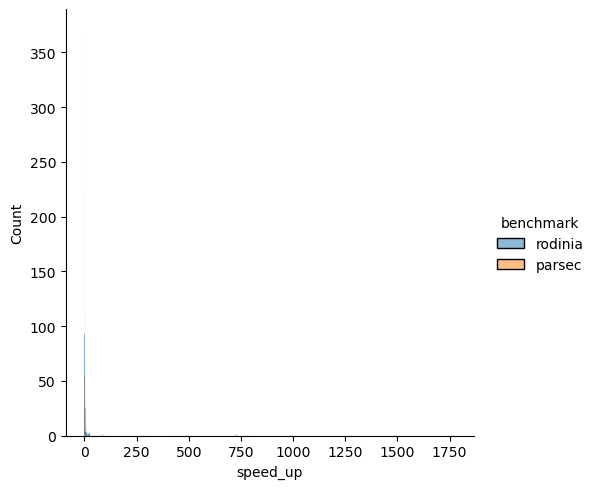

In [4]:
sns.displot(df_raw[['speed_up', 'benchmark']], x="speed_up", hue="benchmark")
plt.show()

C:\Users\yingl\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


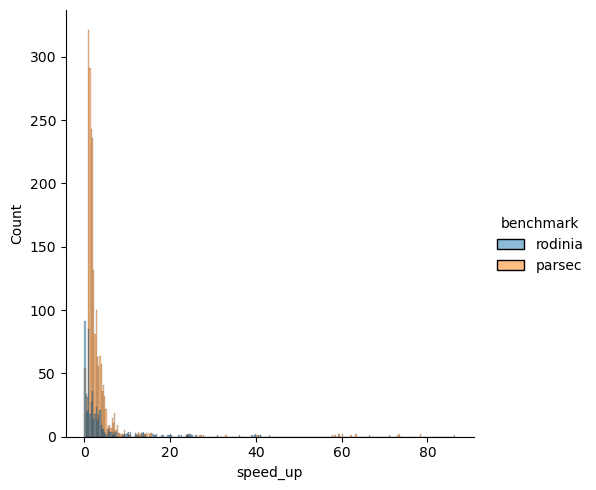

In [5]:
df_raw = df_raw.loc[df_raw['speed_up'] <= 100]
sns.displot(df_raw[['speed_up', 'benchmark']], x="speed_up", hue="benchmark")
plt.show()

<Axes: xlabel='threads', ylabel='speed_up'>

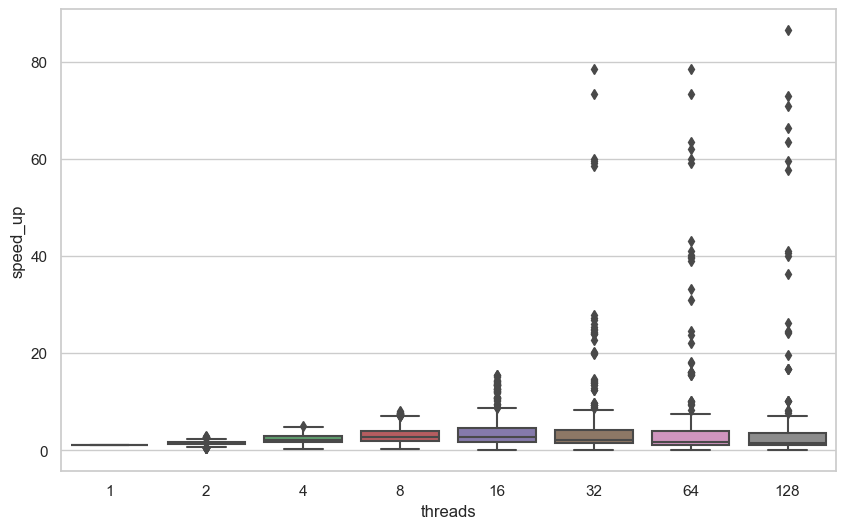

In [6]:
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid') 
sns.boxplot(x="threads",
                y="speed_up",
                data=df_raw[['speed_up', 'threads', 'benchmark']])

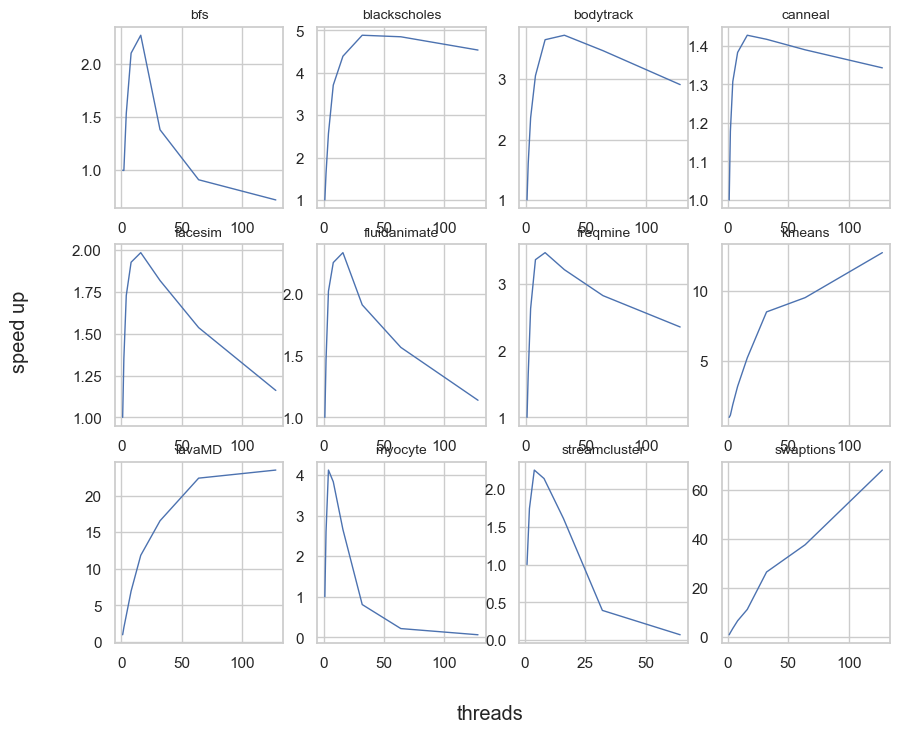

In [7]:
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
p_list = sorted(list(set(df_raw['program'])))
for i, ax in enumerate(axes.flatten()):
    p = p_list[i]
    df_slice = df_raw[['threads', 'speed_up', 'program']].loc[df_raw['program'] == p].groupby(['program', 'threads']).mean().reset_index()
    ax.plot(df_slice['threads'], df_slice['speed_up'], linewidth=1.0)
    ax.set_title(p, size=10)

fig.supxlabel('threads')
fig.supylabel('speed up')
plt.show()

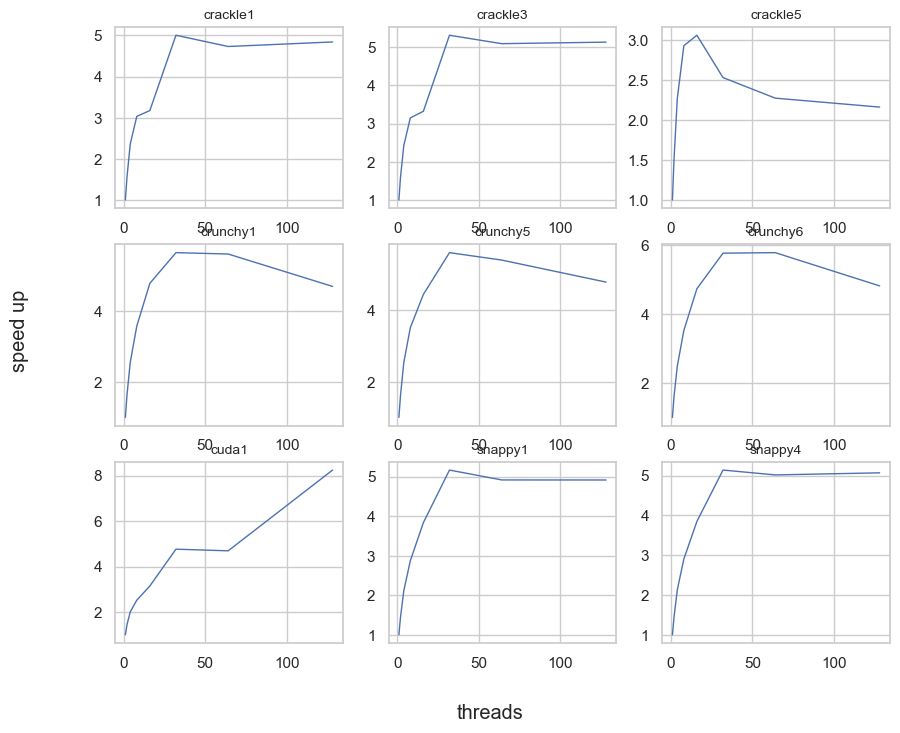

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(10, 8))
h_list = sorted(list(set(df_raw['hostname'])))
for i, ax in enumerate(axes.flatten()):
    h = h_list[i]
    df_slice = df_raw[['threads', 'speed_up', 'hostname']].loc[df_raw['hostname'] == h].groupby(['hostname', 'threads']).mean().reset_index()
    ax.plot(df_slice['threads'], df_slice['speed_up'], linewidth=1.0)
    ax.set_title(h, size=10)

fig.supxlabel('threads')
fig.supylabel('speed up')
plt.show()

## Missing Data

In [9]:
class_feature_lst = []
numeric_feature_lst = []

for col in list(df_raw): 
    null_pct = df_raw[col].isnull().sum() / len(df_raw)
    if null_pct <= 0.2:
        #print(col, null_pct, df_raw.dtypes[col], df_raw.iloc[0])
        if df_raw.dtypes[col] == 'object':
            class_feature_lst.append(col)
        else:
            numeric_feature_lst.append(col)

numeric_feature_lst.remove('speed_up')
numeric_feature_lst.remove('compute_time')
print(numeric_feature_lst)
print(class_feature_lst)

['branch-instructions', 'branch-misses', 'cache-misses', 'cache-references', 'cpu-cycles', 'instructions', 'stalled-cycles-frontend', 'alignment-faults', 'bpf-output', 'context-switches', 'cpu-clock', 'cpu-migrations', 'dummy', 'emulation-faults', 'major-faults', 'minor-faults', 'page-faults', 'task-clock', 'L1-dcache-load-misses', 'L1-dcache-loads', 'L1-dcache-prefetch-misses', 'L1-icache-load-misses', 'LLC-load-misses', 'LLC-loads', 'LLC-stores', 'branch-load-misses', 'branch-loads', 'dTLB-load-misses', 'dTLB-loads', 'iTLB-load-misses', 'iTLB-loads', 'msr/aperf/', 'msr/mperf/', 'msr/tsc/', 'threads', 'host_cpu_user', 'host_cpu_system', 'host_cpu_idle', 'host_memused', 'CPU(s)', 'Thread(s) per core', 'Core(s) per socket', 'Socket(s)', 'NUMA node(s)', 'CPU family', 'Model', 'Stepping', 'CPU MHz', 'BogoMIPS', 'runtime_serial', 'IPC', 'IPS']
['size', 'run_time', 'benchmark', 'run_id', 'program', 'hostname', 'Architecture', 'CPU op-mode(s)', 'Byte Order', 'On-line CPU(s) list', 'Vendor ID

# Feature Examine

length after dropping: 2234


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\2929058954.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


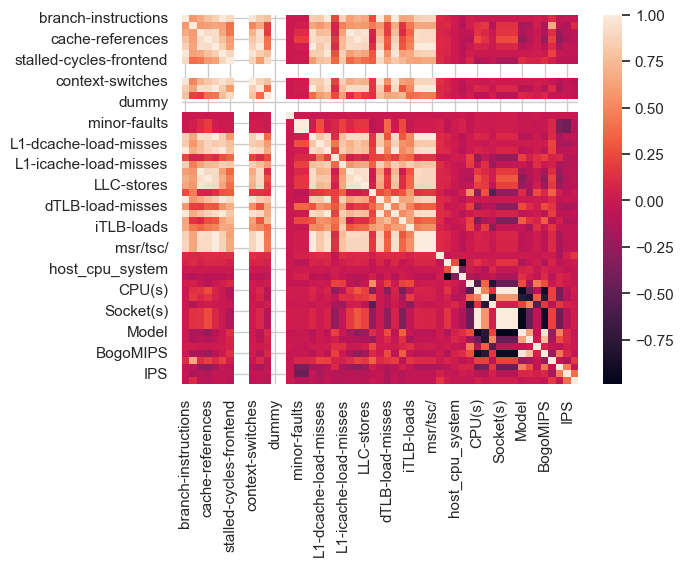

In [10]:
# take out null
df = df_raw[numeric_feature_lst + ['speed_up']]
sns.heatmap(df.corr())
# for col in list(df):
#     df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(inplace=True)
print(f'length after dropping: {len(df)}')

# return df
# df = preprocess_training(df_raw)

## Numerical Feature (p value)

In [11]:
X = df[numeric_feature_lst]
y = df['speed_up']

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:               speed_up   R-squared:                       0.430
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     40.35
Date:                Tue, 16 Apr 2024   Prob (F-statistic):          6.70e-234
Time:                        22:57:25   Log-Likelihood:                -6778.2
No. Observations:                2234   AIC:                         1.364e+04
Df Residuals:                    2192   BIC:                         1.388e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

## Categorical Feature (chi test)

In [12]:
for to_test in class_feature_lst:
    # Create a DataFrame
    #to_test = 'Architecture'
    df_cat_test = df_raw[['speed_up', to_test]]
    
    # Create a contingency table
    table = pd.crosstab(df_cat_test[to_test], df_cat_test['speed_up'])
    
    # Perform the chi-square test
    chi2, p, dof, expected = chi2_contingency(table)
    
    # Interpret the results
    if p < 0.1:
        print('Y --', to_test, p)
    else:
        print('N --', to_test, p)

N -- size 0.3388603240072237
N -- run_time 0.25517469787142555
N -- benchmark 0.3760295656969437
Y -- run_id 0.05050658245661779
N -- program 0.2504308114994181
N -- hostname 0.2894810901816114
N -- Architecture 1.0
N -- CPU op-mode(s) 1.0
N -- Byte Order 1.0
N -- On-line CPU(s) list 0.3567573935697952
N -- Vendor ID 0.42482723426855573
N -- Model name 0.35675739356979225
N -- Virtualization 0.42482723426855573
N -- L1d cache 0.42482723426855573
N -- L1i cache 0.42482723426855573
N -- L2 cache 0.42482723426855573
N -- L3 cache 0.3567573935697952
N -- NUMA node0 CPU(s) 0.3567573935697952
N -- NUMA node1 CPU(s) 0.3567573935697952
N -- total_memory 0.38568132475947114


## PCA for Virtulization

In [13]:
df_pca = df_raw[numeric_feature_lst + ['benchmark']]
df_pca.dropna(inplace=True)

d = {}
d['data'] = df_pca[numeric_feature_lst]
d['benchmark'] = df_pca['benchmark']

C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\1446170956.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pca.dropna(inplace=True)


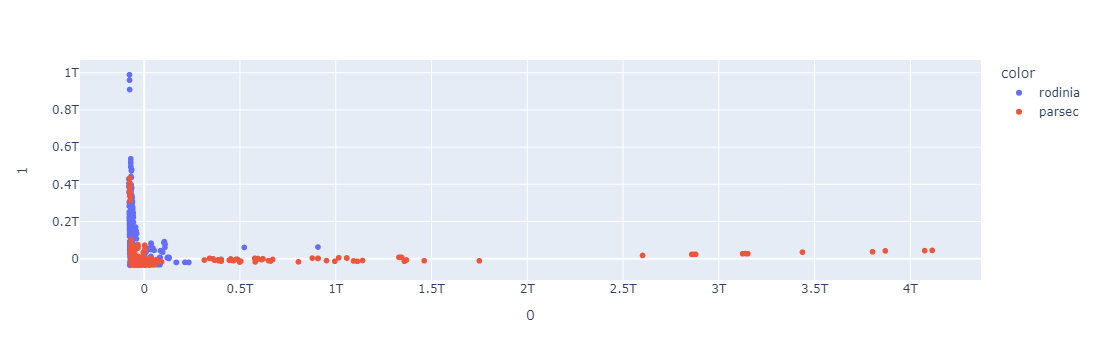

In [14]:
pca = PCA(n_components=2)
components = pca.fit_transform(d['data'])

fig = px.scatter(components, x=0, y=1, color=d['benchmark'])
fig.show()

# Preprocess data

## Train Test Split

In [15]:
df_tmp = df_raw[numeric_feature_lst + ['speed_up', 'hostname', 'program']]
df_tmp.dropna(inplace=True)

df_train = df_tmp.loc[df_tmp['hostname'] != 'crunchy6']
df_test = df_tmp.loc[df_tmp['hostname'] == 'crunchy6']

print(f'df_train length {len(df_train)}, df_test length {len(df_test)}')

X_train = df_train[numeric_feature_lst]
y_train = df_train['speed_up']
X_test = df_test[numeric_feature_lst]
y_test = df_test['speed_up']
df_result = df_test[['speed_up', 'threads', 'program']]

df_train length 2011, df_test length 223


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\3988477311.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
X_train_random = X_train.copy()
X_test_random = X_test.copy()
X_train_random["RANDOM"] = np.random.RandomState(42).randn(X_train.shape[0])
X_test_random["RANDOM"] = np.random.RandomState(42).randn(X_test.shape[0])

In [17]:
numeric_selected_feature_lst = ['CPU(s)','cpu-cycles','host_memused','dTLB-loads','L1-dcache-loads','instructions','branch-loads',
'Stepping','CPU MHz','LLC-stores','LLC-load-misses','CPU family','BogoMIPS','branch-load-misses','context-switches','cache-misses',
'cpu-migrations','iTLB-loads','msr/mperf/','branch-instructions','task-clock','L1-dcache-prefetch-misses',
#'compute_time',
'msr/tsc/','threads','cpu-clock','branch-misses','stalled-cycles-frontend','minor-faults','L1-icache-load-misses','dTLB-load-misses',
'iTLB-load-misses','page-faults','L1-dcache-load-misses','LLC-loads','IPC','cache-references','runtime_serial','IPS',]

df_tmp_2 = df_raw[numeric_selected_feature_lst + ['speed_up', 'hostname']]
df_tmp_2.dropna(inplace=True)

df_train_limited = df_tmp_2.loc[df_tmp_2['hostname'] != 'crunchy6']
df_test_limited = df_tmp_2.loc[df_tmp_2['hostname'] == 'crunchy6']

print(f'df_train length {len(df_train)}, df_test length {len(df_test)}')

X_train_limited = df_train_limited[numeric_selected_feature_lst]
y_train_limited = df_train_limited['speed_up']
X_test_limited = df_test_limited[numeric_selected_feature_lst]
y_test_limited = df_test_limited['speed_up']

df_train length 2011, df_test length 223


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\3932590972.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Normalization

In [18]:
scaler = StandardScaler().fit(X_train) 
X_train_std = scaler.transform(X_train) 
X_test_std = scaler.transform(X_test) 

# Prediction

In [19]:
df_result

speed_up  threads    program
0    1.000000        1        bfs
1    1.445450        2        bfs
2    2.453439        4        bfs
3    3.814242        8        bfs
4    3.790494       16        bfs
..        ...      ...        ...
0    1.000000        1  swaptions
1    1.944333        2  swaptions
2    3.667928        4  swaptions
3    6.387150        8  swaptions
4   12.837748       16  swaptions

[223 rows x 3 columns]

## 1) Linear Regression

### 1.1) Linear Regression with selected features

In [20]:
# def predict_regression(df):
#     X = df[numeric_feature_lst]
#     y = df['speed_up']

#     # Split the DataFrame into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#     # Create a scikit-learn model
#     model = LinearRegression()

#     # Fit the model to the training data
#     model.fit(X_train, y_train)

#     # Make predictions on the testing data
#     y_pred = model.predict(X_test) # need to cap it >= 0

#     # Evaluate the model's performance
#     print('model.score', model.score(X_test, y_test))
#     # print('RMSE', root_mean_squared_error(y_test, y_pred))
#     print('MSE', mean_squared_error(y_test, y_pred))
#     print('MAE', mean_absolute_error(y_test, y_pred))

# predict_regression(df)

In [22]:
def perform_linear_and_ridge_regression(X_train, X_test, y_train, y_test):
    # X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0) 
    lin_reg_parameters = { 'fit_intercept': [True, False] }
    lin_reg = GridSearchCV(LinearRegression(), lin_reg_parameters, cv=5)
    lin_reg.fit(X=X_train, y=y_train)
    y_pred = lin_reg.predict(X_test)
    # print('model.score', model.score(X_test, y_test))
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

# X_std = transformer.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
perform_linear_and_ridge_regression(X_train, X_test, y_train, y_test)
perform_linear_and_ridge_regression(X_train_std, X_test_std, y_train, y_test)
# perform_linear_and_ridge_regression(X=X, Y=y)

MSE 18.263505764081053
MAE 2.5669553821475053
MSE 18.263509075173026
MAE 2.5669550187903982


### 1.2) Linear regression w/ L1 regularization

In [23]:
def perform_lr_l1(X_train, X_test, y_train, y_test):
    reg = linear_model.Lasso(alpha=0.1)
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))

perform_lr_l1(X_train, X_test, y_train, y_test)
perform_lr_l1(X_train_std, X_test_std, y_train, y_test)

MSE 19.586783168604978
MAE 2.5937254893209896
MSE 22.025947893117134
MAE 2.7450394212663967


C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.827e+04, tolerance: 9.111e+00



In [24]:
# reg = LassoCV(cv=5, random_state=0).fit(X_train_std, y_train)
# y_pred = reg.predict(X_test_std)
# print('MSRE', mean_squared_error(y_test, y_pred))
# print('MAE', mean_absolute_error(y_test, y_pred))

### 1.3)* Linear regression w/ L2 regularization

In [25]:
def perform_lr_l2(X_train, X_test, y_train, y_test):
    ridgecv = linear_model.RidgeCV(alphas=[0.001, 0.01, 0.1, 0.5, 1, 10], cv=5)
    ridgecv.fit(X_train, y_train) # not converging is not std
    y_pred = ridgecv.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    df_result['lr_l2'] = y_pred

perform_lr_l2(X_train, X_test, y_train, y_test)
# perform_lr_l2(X_train_std, X_test_std, y_train, y_test)

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.74671e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.69755e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.68756e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.71363e-30): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=5.70789e-29): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.14919e-29): result may not be acc

MSE 18.263982994094224
MAE 2.5668238341663545


C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.09694e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.08662e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=4.11468e-26): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=5.71103e-25): result may not be accurate.

C:\Users\yingl\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=3.6716e-30): result may not be accurate.

C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\2064807063.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Tr

## 2)* KNN 

In [26]:
def perform_knn(X_train, X_test, y_train, y_test):
    #create new a knn model
    knn2 = KNeighborsRegressor()
    #create a dictionary of all values we want to test for n_neighbors
    param_grid = {'n_neighbors': np.arange(1, 25)}
    #use gridsearch to test all values for n_neighbors
    knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
    #fit model to data
    knn_gscv.fit(X_train, y_train)
    rf = KNeighborsRegressor(n_neighbors = knn_gscv.best_params_['n_neighbors'])
    
    y_pred = knn_gscv.predict(X_test)
    # print('RMSE', root_mean_squared_error(y_test, y_pred))
    print('MSE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    df_result['knn'] = y_pred

perform_knn(X_train, X_test, y_train, y_test)
# perform_knn(X_train_std, X_test_std, y_train, y_test)

MSE 8.708802125966157
MAE 1.2657873414670053


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\2542152999.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### w/ Limited Feature

In [27]:
perform_knn(X_train_limited, X_test_limited, y_train, y_test)

MSE 8.743654635390525
MAE 1.2664770220474932


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\2542152999.py:16: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 3)* Random Forest - Bagging

MSRE 0.4986699749532806
MAE 0.2769852090760171


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\4078246509.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



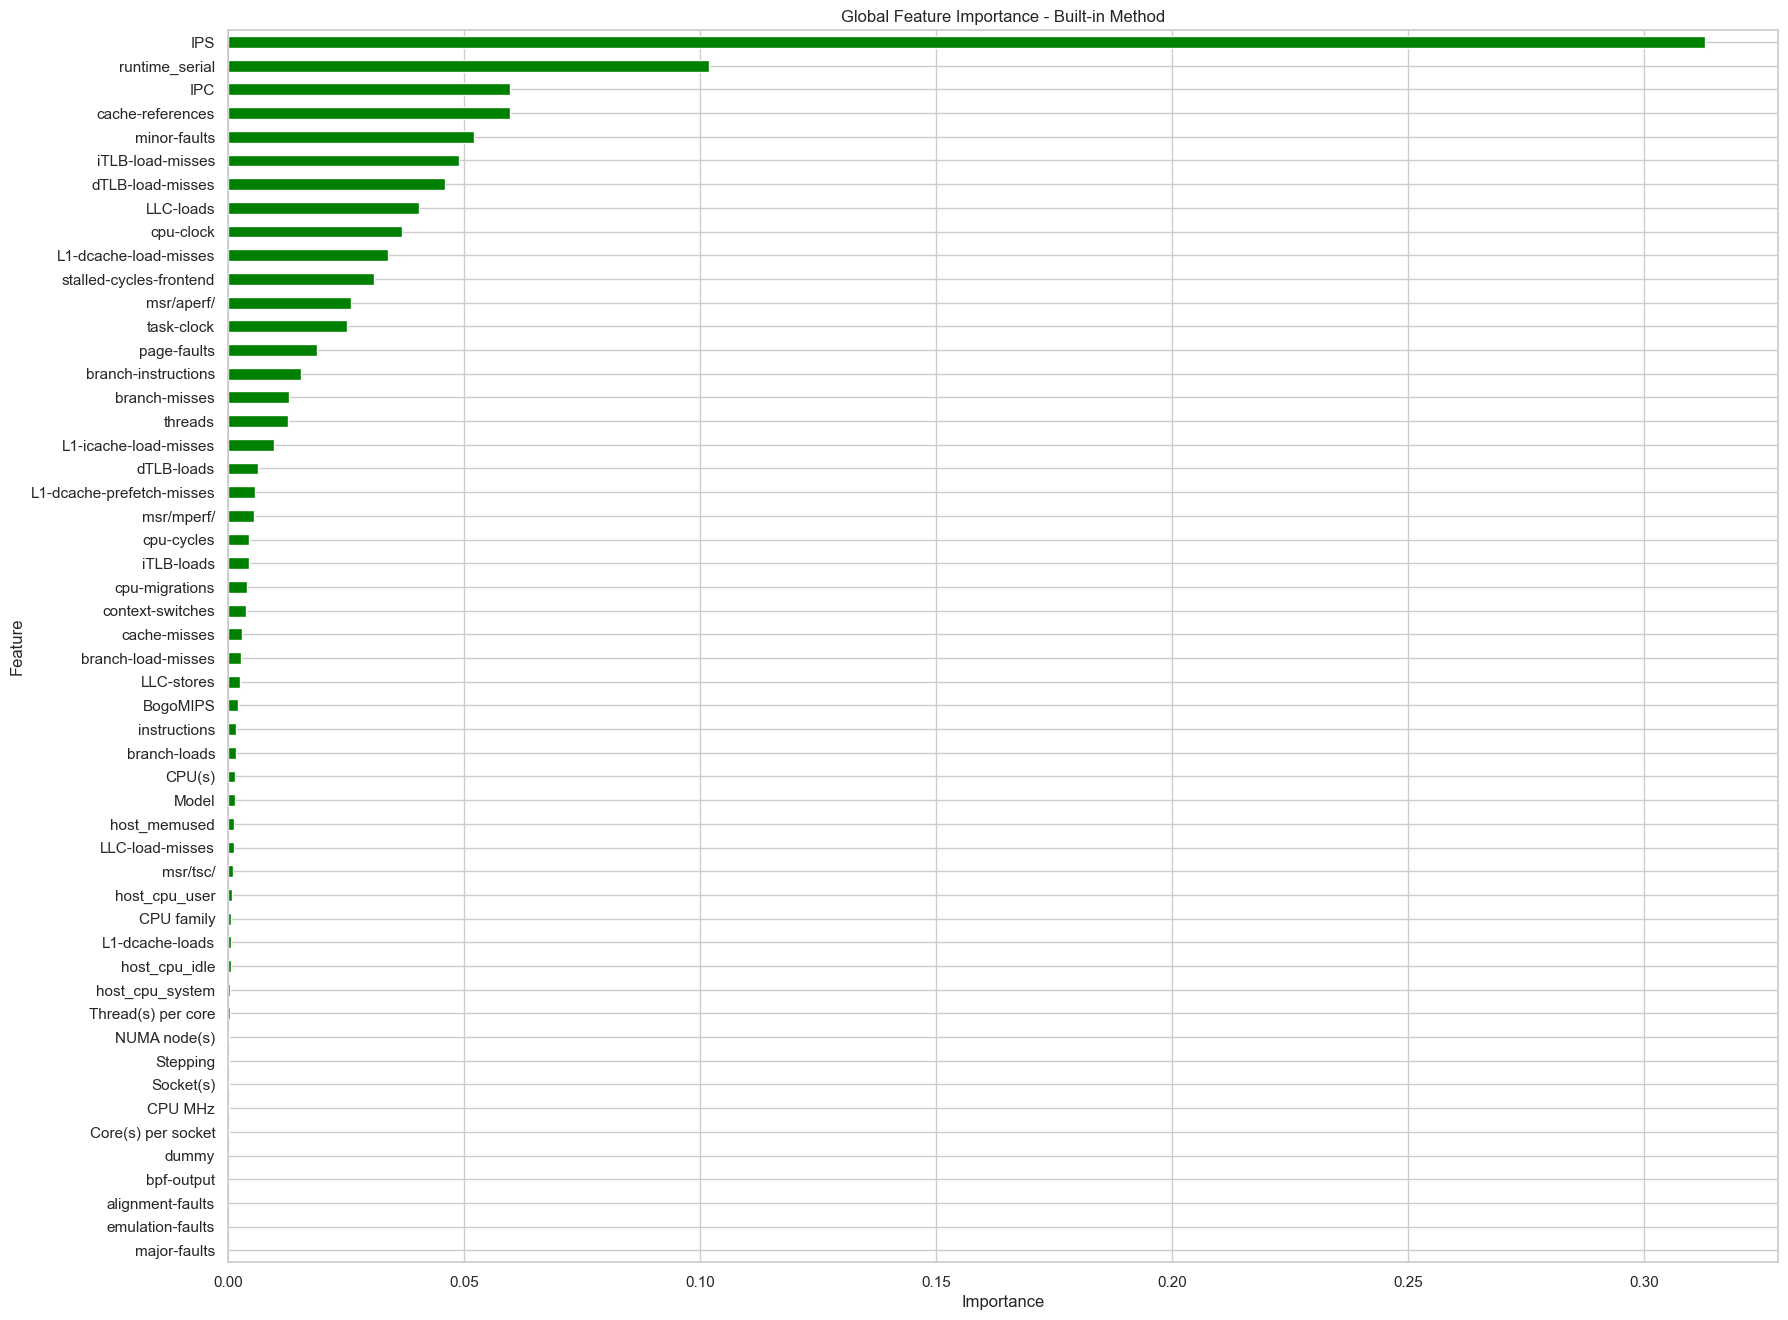

In [28]:
def perform_rf(X_train, X_test, y_train, y_test):
    param_grid = {
        'max_depth': [5,10,20,30],
        'max_features' : [5,10,20,30],
        'n_estimators': [20,50]}
    
    grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=0), 
                               param_grid=param_grid,
                               cv=KFold(n_splits=5, shuffle=True, random_state=1))
    
    grid_search.fit(X_train, y_train)
    rf = RandomForestRegressor(n_estimators = grid_search.best_params_['n_estimators'],
                               max_features = grid_search.best_params_['max_features'],
                               max_depth = grid_search.best_params_['max_depth'],
                               random_state = 0)
    
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_test)
    print('MSRE', mean_squared_error(y_test, y_pred))
    print('MAE', mean_absolute_error(y_test, y_pred))
    df_result['random_forest'] = y_pred
    
    plt.figure(figsize=(20, 16))
    global_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
    global_importances.sort_values(ascending=True, inplace=True)
    global_importances.plot.barh(color='green')
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Global Feature Importance - Built-in Method")

perform_rf(X_train, X_test, y_train, y_test)
# perform_knn(X_train_std, X_test_std, y_train, y_test)

### RF: Feature Importance w/ Random

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

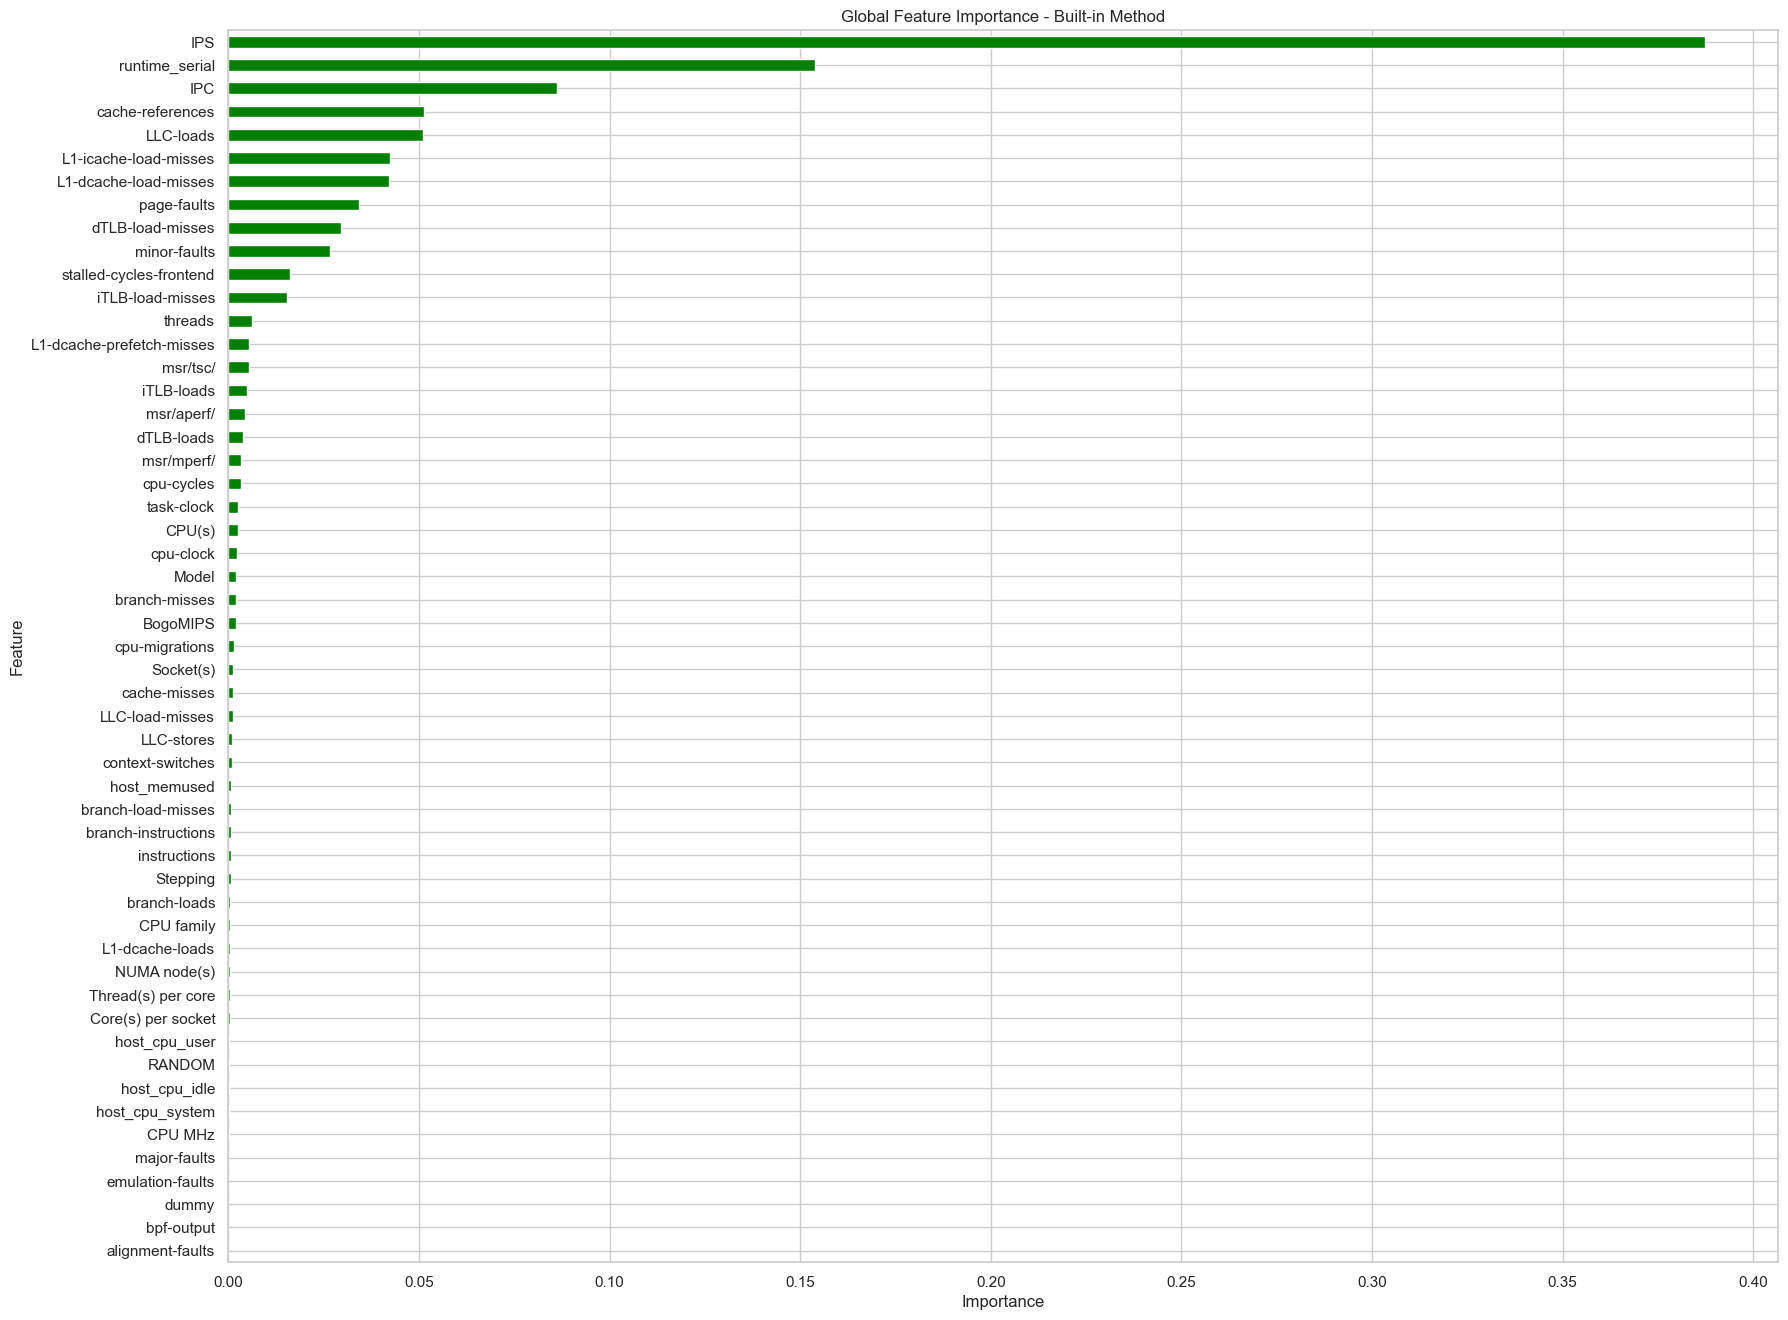

In [30]:
rf_random = RandomForestRegressor(n_estimators=100, random_state=42)
rf_random.fit(X_train_random, y_train)

global_importances_random = pd.Series(rf_random.feature_importances_, index=X_train_random.columns)
global_importances_random.sort_values(ascending=True, inplace=True)

plt.figure(figsize=(20, 16))
global_importances_random.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

In [31]:
global_importances_random

alignment-faults             0.000000
bpf-output                   0.000000
dummy                        0.000000
emulation-faults             0.000000
major-faults                 0.000000
CPU MHz                      0.000037
host_cpu_system              0.000088
host_cpu_idle                0.000165
RANDOM                       0.000177
host_cpu_user                0.000181
Core(s) per socket           0.000307
Thread(s) per core           0.000360
NUMA node(s)                 0.000386
L1-dcache-loads              0.000421
CPU family                   0.000450
branch-loads                 0.000520
Stepping                     0.000604
instructions                 0.000614
branch-instructions          0.000697
branch-load-misses           0.000793
host_memused                 0.000801
context-switches             0.000995
LLC-stores                   0.001073
LLC-load-misses              0.001092
cache-misses                 0.001187
Socket(s)                    0.001191
cpu-migratio

## 4) Boosting

### 4.1) Gradient Boosting

In [32]:
gb_reg = GradientBoostingRegressor(random_state=0)
gb_reg.fit(X_train, y_train)
y_pred = gb_reg.predict(X_test)
# print('RMSE', root_mean_squared_error(y_test, y_pred))
print('MSE', mean_squared_error(y_test, y_pred))
print('MAE', mean_absolute_error(y_test, y_pred))
df_result['gradient_boost'] = y_pred

MSE 0.5147033430154405
MAE 0.41750904198841166


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\2014355863.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Feature Importance

Text(0.5, 1.0, 'Global Feature Importance - Built-in Method')

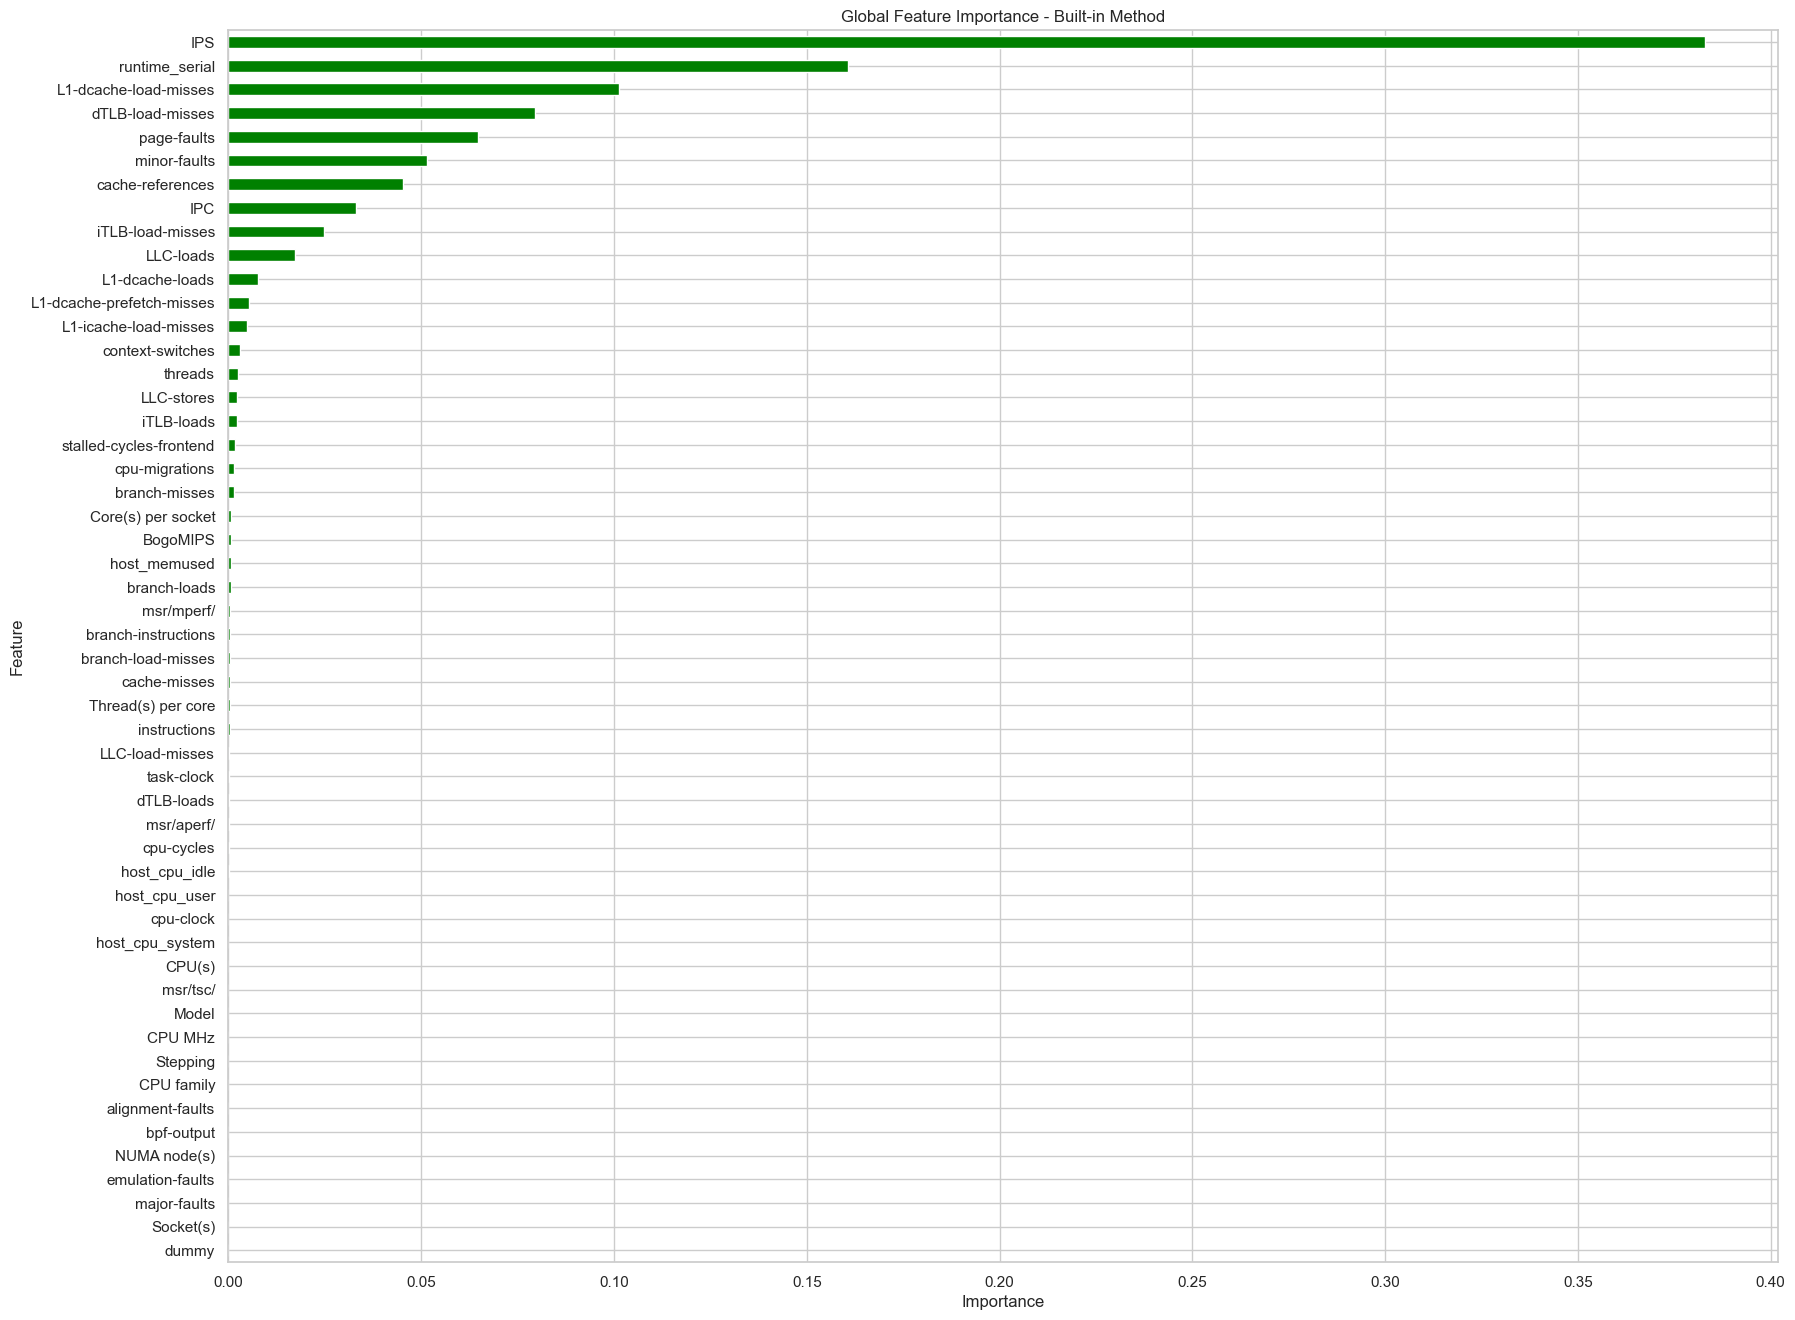

In [33]:
# print(reg.feature_importances_)
plt.figure(figsize=(20, 16))
global_importances = pd.Series(gb_reg.feature_importances_, index=X_train.columns)
global_importances.sort_values(ascending=True, inplace=True)
global_importances.plot.barh(color='green')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Global Feature Importance - Built-in Method")

### 4.2)* XgBoosting

https://www.kaggle.com/code/carlmcbrideellis/an-introduction-to-xgboost-regression

In [34]:
xg_regressor=xgb.XGBRegressor(eval_metric='rmsle')
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(xg_regressor, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

xg_regressor=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmse') # mae

xg_regressor.fit(X_train, y_train)
predictions = xg_regressor.predict(X_test)

# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))
df_result['xgboost'] = predictions

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MSE 0.27784825211538394
MAE 0.3125122440967919


C:\Users\yingl\AppData\Local\Temp\ipykernel_8720\3078268296.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### Feature Importance

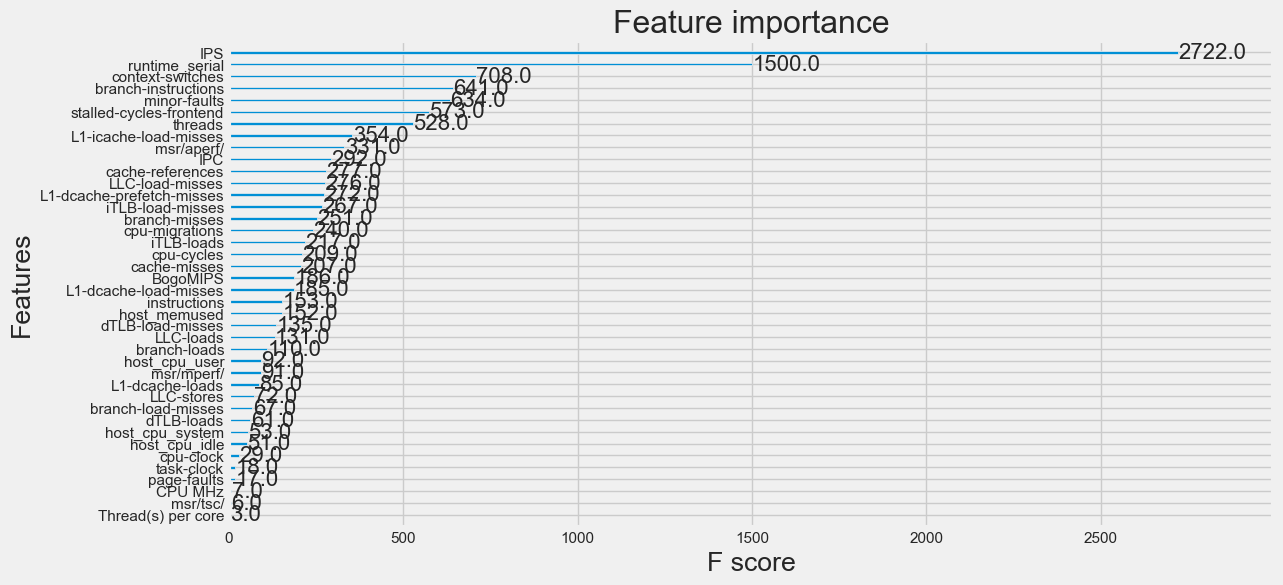

In [35]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(12,6))
plot_importance(xg_regressor, max_num_features=50, ax=ax)
plt.show()

#### Feature Importance w/ Random

The best hyperparameters are  {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 500}
MSE 0.2683949135822221
MAE 0.3113954345154314


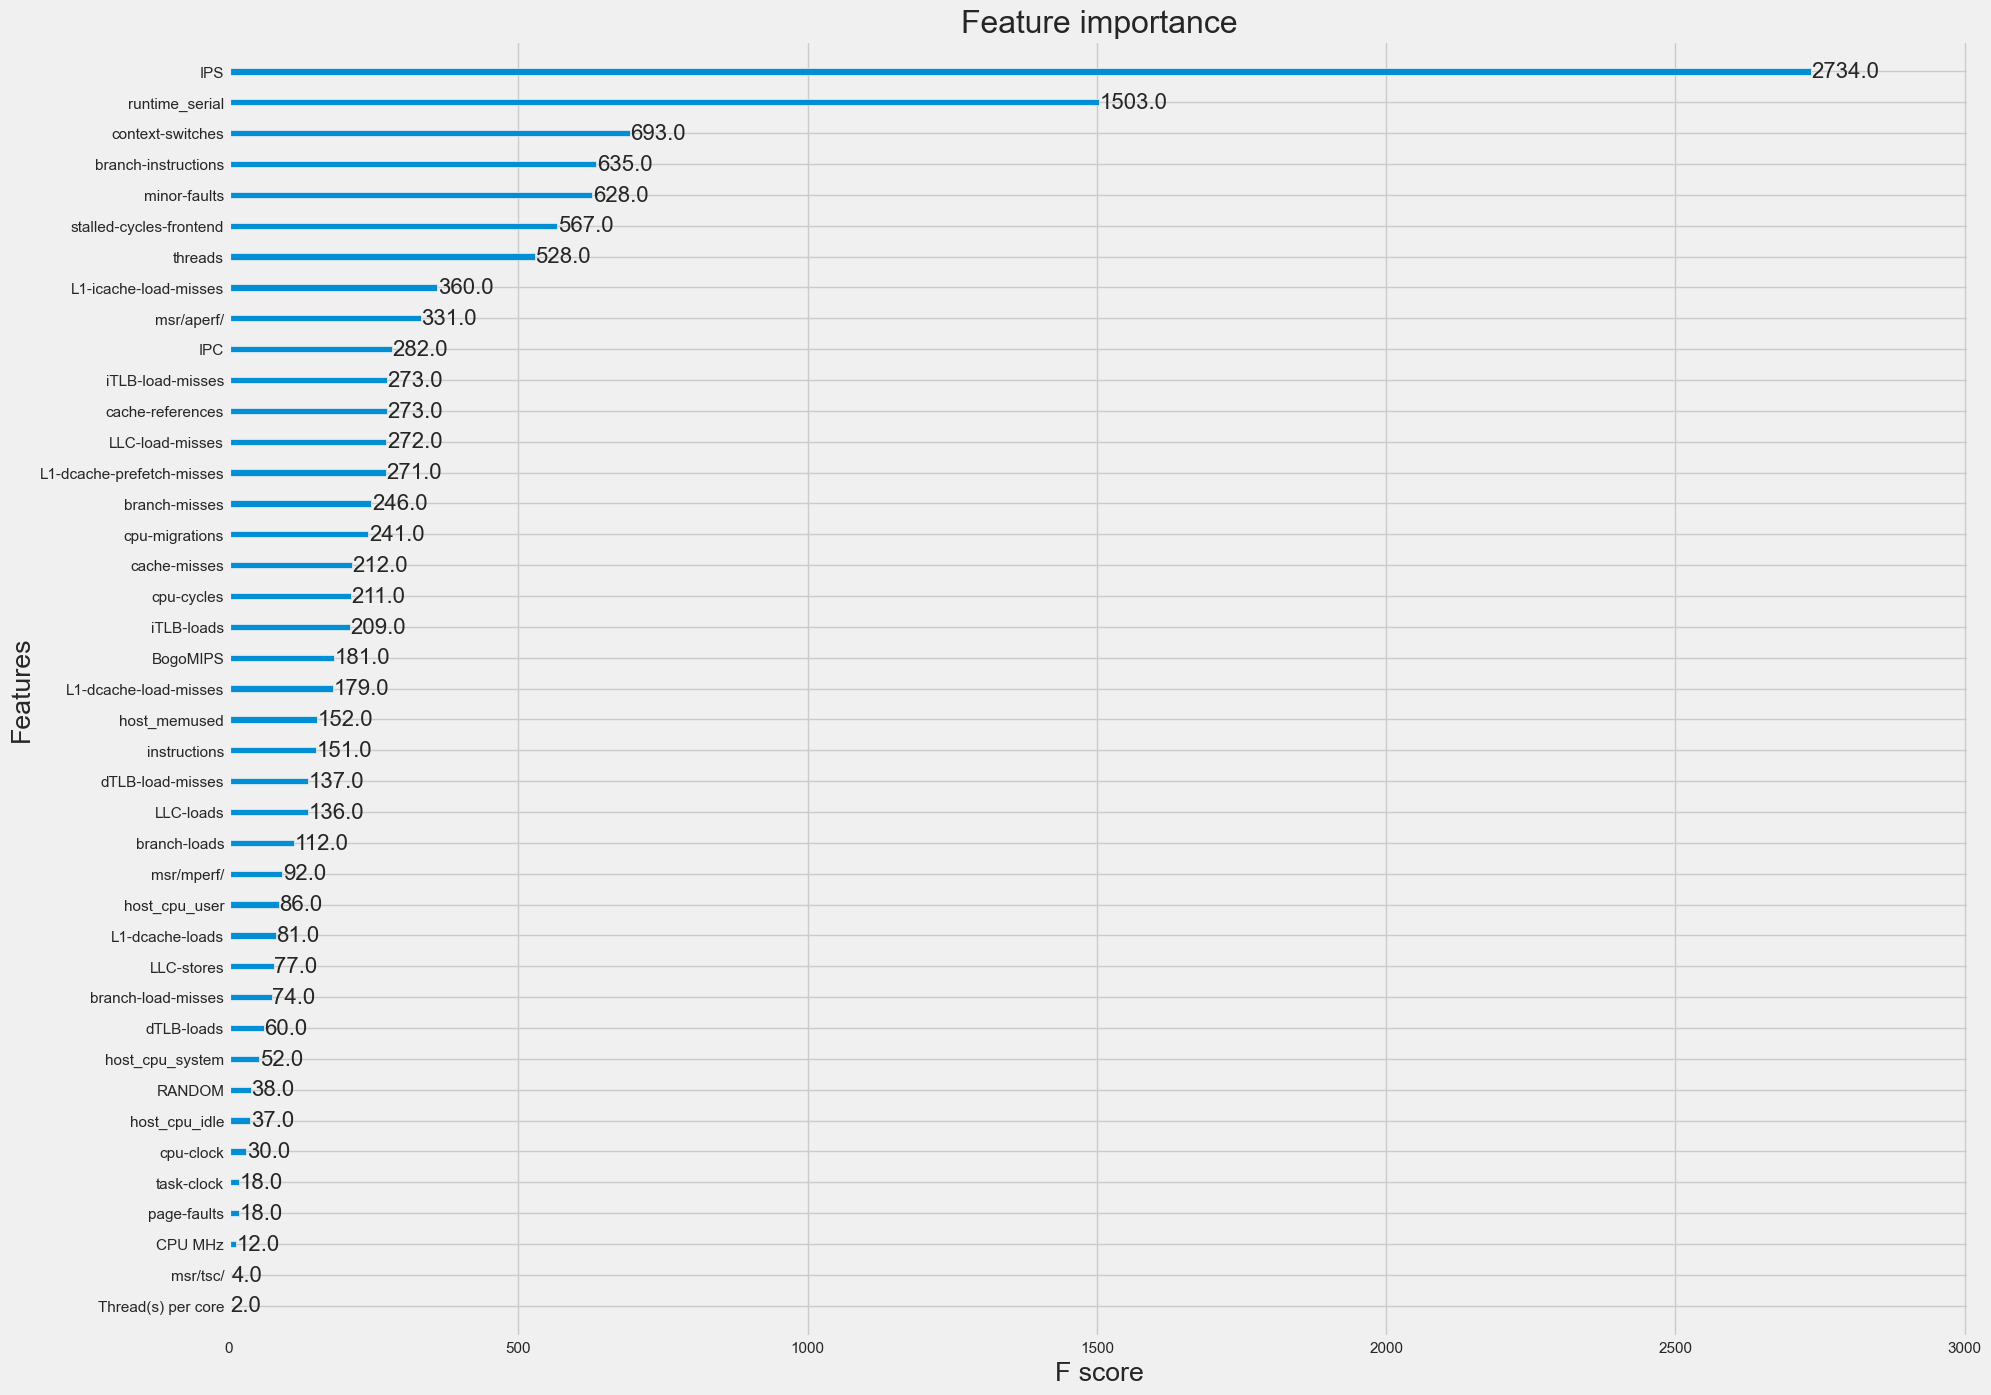

In [36]:
xg_regressor_rn =xgb.XGBRegressor(eval_metric='rmsle')
param_grid = {"max_depth":    [4, 5, 6],
              "n_estimators": [500, 600, 700],
              "learning_rate": [0.01, 0.015]}

# try out every combination of the above values
search = GridSearchCV(xg_regressor_rn, param_grid, cv=5).fit(X_train, y_train)

print("The best hyperparameters are ",search.best_params_)

xg_regressor_rn=xgb.XGBRegressor(learning_rate = search.best_params_["learning_rate"],
                           n_estimators  = search.best_params_["n_estimators"],
                           max_depth     = search.best_params_["max_depth"],
                           eval_metric='rmsle')

xg_regressor_rn.fit(X_train_random, y_train)
predictions = xg_regressor_rn.predict(X_test_random)

# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(figsize=(20,16))
plot_importance(xg_regressor_rn, max_num_features=50, ax=ax)
plt.show()

## (optional) Neural Network

In [37]:
clf = MLPRegressor(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
# print('RMSE', root_mean_squared_error(y_test, predictions))
print('MSE', mean_squared_error(y_test, predictions))
print('MAE', mean_absolute_error(y_test, predictions))

MSE 31.048872039430027
MAE 2.7435938129452238


## Summary

In [42]:
print('-------------- all')
df_result = df_result[df_result['threads'] != 1]
print('MSE', mean_squared_error(df_result['speed_up'], df_result['lr_l2']))
print('MSE', mean_squared_error(df_result['speed_up'], df_result['knn']))
print('MSE', mean_squared_error(df_result['speed_up'], df_result['random_forest']))
print('MSE', mean_squared_error(df_result['speed_up'], df_result['gradient_boost']))
print('MSE', mean_squared_error(df_result['speed_up'], df_result['xgboost']))

for t in sorted(set(df_result['threads'])):
    print('--------------', t)
    df_result_sub = df_result[df_result['threads'] == t]
    print('MSE', mean_squared_error(df_result_sub['speed_up'], df_result_sub['lr_l2']))
    print('MSE', mean_squared_error(df_result_sub['speed_up'], df_result_sub['knn']))
    print('MSE', mean_squared_error(df_result_sub['speed_up'], df_result_sub['random_forest']))
    print('MSE', mean_squared_error(df_result_sub['speed_up'], df_result_sub['gradient_boost']))
    print('MSE', mean_squared_error(df_result_sub['speed_up'], df_result_sub['xgboost']))

-------------- all
MSE 19.51164386471562
MSE 9.702962276025316
MSE 0.5318719138188693
MSE 0.5765539779829469
MSE 0.31378322996781016
-------------- 2
MSE 7.844468417737685
MSE 0.9277877933879357
MSE 0.1162295640820079
MSE 0.08374960562439229
MSE 0.047253244501073675
-------------- 4
MSE 5.13044822596368
MSE 0.3928111029302665
MSE 0.04053220543663585
MSE 0.10403350420365323
MSE 0.07104175297837222
-------------- 8
MSE 5.0118548856727845
MSE 1.3718480125818695
MSE 0.06097326486965735
MSE 0.40562636024078885
MSE 0.22380752407473783
-------------- 16
MSE 12.13290984234894
MSE 8.508481445835995
MSE 0.17832863015594477
MSE 0.23690890272086354
MSE 0.21578501842581174
-------------- 32
MSE 33.202845566563795
MSE 16.80731261651492
MSE 0.3653749883292113
MSE 1.2924573756603923
MSE 0.5932685824111987
-------------- 64
MSE 44.08228812261476
MSE 25.16765275153036
MSE 1.8896037551303972
MSE 0.8613335925280674
MSE 0.17616675264735698
-------------- 128
MSE 31.581112907895733
MSE 16.000557836325406
MS

In [48]:
print('-------------- all')
print('MAE', mean_absolute_error(df_result['speed_up'], df_result['lr_l2']))
print('MAE', mean_absolute_error(df_result['speed_up'], df_result['knn']))
print('MAE', mean_absolute_error(df_result['speed_up'], df_result['random_forest']))
print('MAE', mean_absolute_error(df_result['speed_up'], df_result['gradient_boost']))
print('MAE', mean_absolute_error(df_result['speed_up'], df_result['xgboost']))

for t in sorted(set(df_result['threads'])):
    print('--------------', t)
    df_result_sub = df_result[df_result['threads'] == t]
    print('MAE', mean_absolute_error(df_result_sub['speed_up'], df_result_sub['lr_l2']))
    print('MAE', mean_absolute_error(df_result_sub['speed_up'], df_result_sub['knn']))
    print('MAE', mean_absolute_error(df_result_sub['speed_up'], df_result_sub['random_forest']))
    print('MAE', mean_absolute_error(df_result_sub['speed_up'], df_result_sub['gradient_boost']))
    print('MAE', mean_absolute_error(df_result_sub['speed_up'], df_result_sub['xgboost']))

-------------- all
MAE 2.667573259445177
MAE 1.3413427048619602
MAE 0.2979680829355335
MAE 0.44610576349537967
MAE 0.3347213256217838
-------------- 2
MAE 1.7536210212958077
MAE 0.5680787024250077
MAE 0.1330807042567625
MAE 0.17117848172591182
MAE 0.1597805287413298
-------------- 4
MAE 1.375513412935112
MAE 0.44840347939643677
MAE 0.1373471125032823
MAE 0.2240288382786713
MAE 0.20075060389925706
-------------- 8
MAE 1.632462117569985
MAE 0.8251876122168532
MAE 0.18051909681886266
MAE 0.45820210082630675
MAE 0.3363018571756266
-------------- 16
MAE 2.5043130917558134
MAE 1.701167304940691
MAE 0.267386658109303
MAE 0.3863968295135218
MAE 0.3539184928470085
-------------- 32
MAE 3.427114626713732
MAE 1.930302173023325
MAE 0.3869613590392467
MAE 0.7069233434614469
MAE 0.4775679533356462
-------------- 64
MAE 3.8101673748089047
MAE 2.328163180289381
MAE 0.5717556907478993
MAE 0.5300809770434264
MAE 0.304143629676937
-------------- 128
MAE 4.465079673212116
MAE 1.646448752986961
MAE 0.43533